## Comparision of  MC estimate of statistics using Fipy(ground truth) vs statistics by Deep Neural Network with 'n samples' each

In [1]:
#load libraries 
from __future__ import division
import argparse

import matplotlib
matplotlib.use('PS')
%matplotlib inline
import tensorflow as tf
import random 
import numpy as np
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.models import Model
from keras.layers import Dense, Activation, Input, concatenate, Lambda, Add
from keras.utils import plot_model
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import matplotlib.pyplot as plt 
import GPy
from fipy import *
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 300
import seaborn as sns 
sns.set_context('paper')
sns.set_style('white')
from pdb import set_trace as keyboard
import sys
import time 
# plt.rcParams["patch.force_edgecolor"] = True

/Users/sharmila/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# maindir='/Users/sharmila/Desktop/research/work/03_NN_PDE/Level3/part8_image/1_Study_EF_Vs_SR_c=15_f=10'
# Taking needed inputs and loading files

# Load files
# load cellcenters data
cellcenters = np.load('cellcenters_nx=100.npy')
# load MC input samples [conductivity] # these inputs are already bounded.
MC_inputfield = np.load('MC_samples_inputfield_exp_nx=100_lx=0.03_v=1.0_num_samples=100000.npy')
# load MC samples fipy # the below fipy file is for bounded inputs itself.
MC_u_fipy = np.load('MC_samples_u_fipy_exp_nx=100_lx=0.03_v=1.0_num_samples=100000.npy')

# DNN surrogate inputs
############################
DNN_type = 'Resnet'
act_func = 'swish'
n = 400 # Number of neurons in each block
num_block = 3 # Number of blocks
############################
DNN_weights_path='my_model_weights.h5'


In [3]:
print cellcenters.shape
print MC_inputfield.shape
print MC_u_fipy.shape

(100, 1)
(100000, 100)
(100000, 100)


In [4]:
nx=cellcenters.shape[0]

In [5]:
x_fipy=cellcenters
print x_fipy.shape
# print x_fipy

(100, 1)


### A.ground_using_fipy

In [6]:
print MC_u_fipy.shape
print MC_u_fipy

ground_mean_fipy=np.mean(MC_u_fipy,axis=0)
ground_var_fipy=np.var(MC_u_fipy,axis=0)
print ground_mean_fipy.shape
print ground_var_fipy.shape

(100000, 100)
[[0.99527242 0.98486291 0.97094541 ... 0.05588314 0.03944935 0.02048394]
 [0.98377806 0.96564914 0.95051441 ... 0.11228727 0.07161261 0.01903423]
 [0.9707955  0.94779971 0.93535342 ... 0.05199457 0.03922144 0.01650296]
 ...
 [0.99762225 0.98990495 0.98127212 ... 0.07008059 0.04258624 0.01168542]
 [0.99400605 0.98112502 0.96863396 ... 0.14158137 0.08506876 0.02869384]
 [0.99793188 0.99208308 0.98225392 ... 0.02279205 0.01814918 0.01272935]]
(100,)
(100,)


 /Users/sharmila/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning:No labelled objects found. Use label='...' kwarg on individual plots.


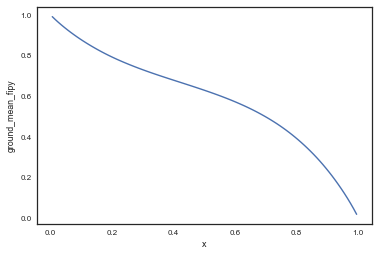

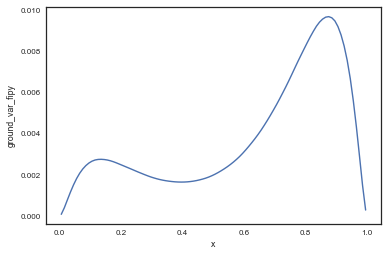

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure()

plt.plot(x_fipy, ground_mean_fipy)
plt.xlabel('x',fontsize = 9)
plt.ylabel('ground_mean_fipy')
plt.legend(loc='best')
plt.show()

plt.plot(x_fipy, ground_var_fipy)
plt.xlabel('x')
plt.ylabel('ground_var_fipy')
plt.legend(loc='best')
plt.show()

[0.505]


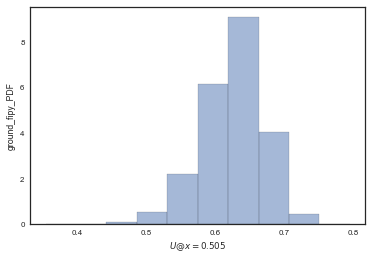

In [8]:
## mid point x=0.505 statistics #location A
print x_fipy[50]

import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.hist(MC_u_fipy[:,50], normed=True, alpha=0.5)
ax.set_xlabel('$U@x=0.505$')
ax.set_ylabel('ground_fipy_PDF')
plt.show()

### B.Neural_network

In [9]:
# ======================
##giving_DNN_architecture
# ------------------------------------------------------------

# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'    
class Swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Swish(swish)})
# ------------------------------------------------------------
# BUILD DNN APPROXIMATOR
# ======================
# DNN network i/p:x,A o/p:prediction

x = Input(shape=(1,))
A = Input(shape=(nx,)) # input field image: conductivity image
a_val = Input(shape=(1,)) # input field value: conductivity value at the corresponding 'input x' location

if DNN_type == 'Resnet':
    x_A = concatenate([x,A])
    o = Dense(n)(x_A)
    for i in range(num_block):
        z = Dense(n, activation = act_func)(o)
        z = Dense(n, activation = act_func)(z)
        o = Add()([z, o])
    prediction = Dense(1)(o)
    print DNN_type

elif DNN_type == 'FC':
    num_neurons_per_layer = map(int, d.strip('[]').split(','))
    x_A = concatenate([x,A])
    z = Dense(num_neurons_per_layer[0], activation=act_func)(x_A)
    for n in num_neurons_per_layer[1:]:
        z = Dense(n, activation=act_func)(z)
    prediction = Dense(1)(z)
    print DNN_type

def myFunc(t):
    B1 = 1 # value_left
    B2 = 0 # value_right
    return ((B1*(1-t[0]))+(B2*t[0])+(t[0]*(1-t[0])*t[1]))

u = Lambda(myFunc, output_shape=(1,))([x,prediction]) # field of interest : temperature
model = Model(inputs=[x,A], outputs=u)


Instructions for updating:
Colocations handled automatically by placer.
Resnet


In [10]:
init = tf.global_variables_initializer()
sess = tf.Session()
K.set_session(sess)
sess.run(init)

print('-------')
model.load_weights(DNN_weights_path)##loading saved weights of the model
# for layer in model.layers:
#     g=layer.get_config()
#     h=layer.get_weights()
#     print (g)
#     print (h)

-------


In [11]:
start = time.time()

nsamples = MC_inputfield.shape[0]

MC_samples_u_DNN = np.zeros((nsamples, nx))  ##evaluating at cell centers

for i in xrange(nsamples):
    #display
    if (i+1)%10000 == 0:
        print "Predicting MC sample "+str(i+1)
        
    a = MC_inputfield[ i , : ].reshape(-1,1)

    u_DNN = sess.run(u, feed_dict={x:x_fipy, A:np.repeat(a.T, np.shape(x_fipy)[0], axis=0)})
    MC_samples_u_DNN[i] = u_DNN.flatten()
    
finish = time.time() - start
print "Time (sec) to generate "+str(MC_inputfield.shape[0])+" MC samples using DNN: " +str(finish)

np.save('MC_samples_u_DNN_exp_nx=32_lx=0.03_v=1.0_num_samples=100000.npy',MC_samples_u_DNN)

Predicting MC sample 10000
Predicting MC sample 20000
Predicting MC sample 30000
Predicting MC sample 40000
Predicting MC sample 50000
Predicting MC sample 60000
Predicting MC sample 70000
Predicting MC sample 80000
Predicting MC sample 90000
Predicting MC sample 100000
Time (sec) to generate 100000 MC samples using DNN: 387.529654026


In [7]:
MC_u_DNN = np.load('MC_samples_u_DNN_exp_nx=32_lx=0.03_v=1.0_num_samples=100000.npy')

In [8]:
print MC_u_DNN.shape
print MC_u_DNN

mean_DNN = np.mean(MC_u_DNN,axis=0)
var_DNN = np.var(MC_u_DNN,axis=0)
print mean_DNN.shape
print var_DNN.shape

(100000, 100)
[[0.99445993 0.98335016 0.9675951  ... 0.06321403 0.04315139 0.0190756 ]
 [0.98092037 0.95709372 0.93710876 ... 0.12162387 0.0919923  0.04058639]
 [0.97740895 0.94892085 0.93227929 ... 0.05346271 0.03981263 0.01717497]
 ...
 [0.99494785 0.98638296 0.97981727 ... 0.06951216 0.04883092 0.02046742]
 [0.99343169 0.98231971 0.9724462  ... 0.18869738 0.1287284  0.04921973]
 [0.9960556  0.9876188  0.97511494 ... 0.01791025 0.01344753 0.00727465]]
(100,)
(100,)


 /Users/sharmila/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning:No labelled objects found. Use label='...' kwarg on individual plots.


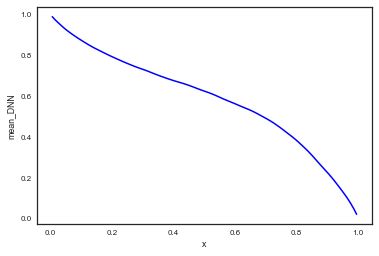

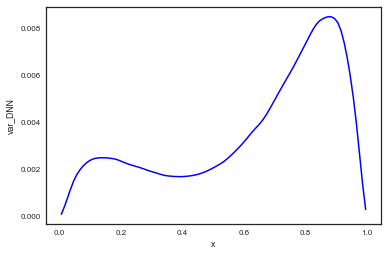

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure()

plt.plot(x_fipy, mean_DNN, 'blue', lw=1.5)
plt.xlabel('x')
plt.ylabel('mean_DNN')
plt.legend(loc='best')
plt.show()

plt.plot(x_fipy,var_DNN, 'blue', lw=1.5)
plt.xlabel('x')
plt.ylabel('var_DNN')
plt.legend(loc='best')
plt.show()

[0.505]


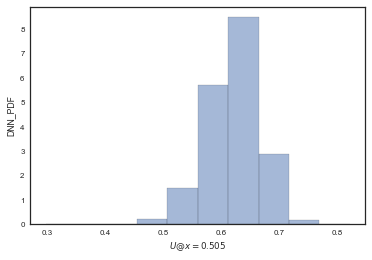

In [12]:
## mid point x=0.505 statistics #location A
print x_fipy[50]

import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.hist(MC_u_DNN[:,50], normed=True, alpha=0.5)
ax.set_xlabel('$U@x=0.505$')
ax.set_ylabel('DNN_PDF')
plt.show()

### C.Comparing Fipy vs NN

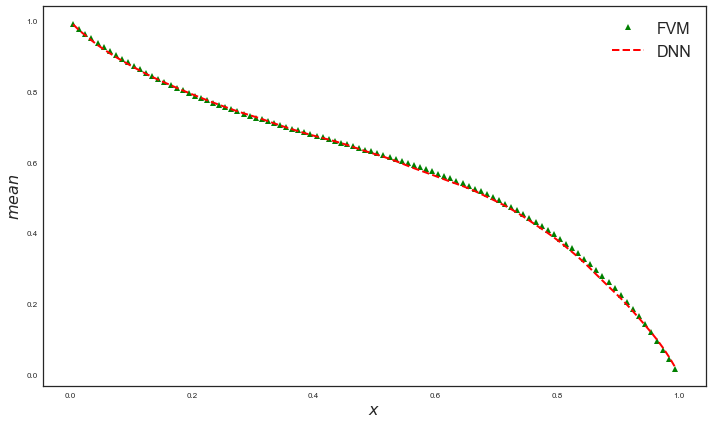

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,6))
# plt.figure(figsize=(6,4))

# plt.scatter(x_fipy, ground_mean_fipy, cmap='Greens') ##ground_fipy

ground_fipy,= plt.plot(x_fipy,  ground_mean_fipy,'g^',lw=2)##ground_fipy
neural_network,= plt.plot(x_fipy, mean_DNN,'r--',lw=2)##neural network

plt.legend([ground_fipy,neural_network], ['FVM','DNN'], fontsize = 16) 
plt.xlabel('$x$', fontsize = 16) 
plt.ylabel('$mean$', fontsize = 16) 
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(),'mean_fipy_vs_DNN.pdf'))
plt.show()

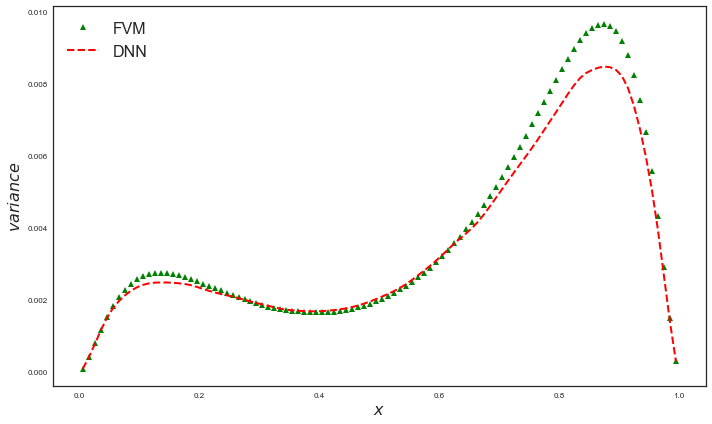

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,6))
# plt.figure(figsize=(6,4))

# plt.scatter(x_fipy, ground_var_fipy, cmap='Greens') ##ground_fipy

ground_fipy,= plt.plot(x_fipy,  ground_var_fipy,'g^',lw=2)##ground_fipy
neural_network,= plt.plot(x_fipy, var_DNN,'r--',lw=2)##neural network

plt.legend([ground_fipy,neural_network], ['FVM','DNN'], fontsize = 16) 
plt.xlabel('$x$', fontsize = 16) 
plt.ylabel('$variance$', fontsize = 16) 
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(),'variance_fipy_vs_DNN.pdf'))
plt.show()

 /Users/sharmila/anaconda/envs/py27/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


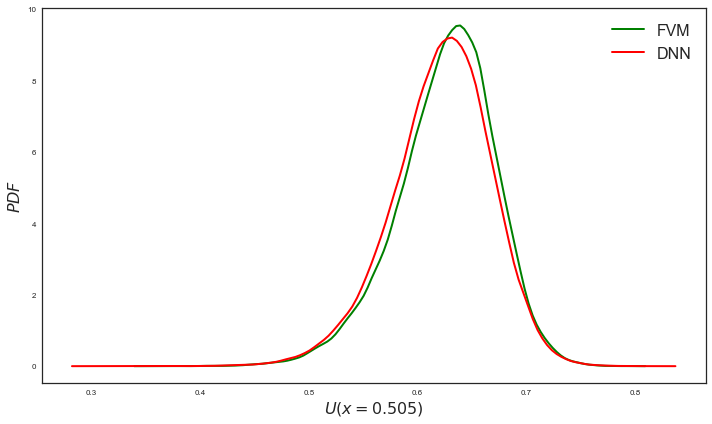

In [10]:
# plt.rcParams.update({'font.size': 30})
plt.rc('legend', fontsize=16) 
fig, ax = plt.subplots(figsize=(10,6))
# fig, ax = plt.subplots(figsize=(6,4))
sns.distplot(MC_u_fipy[:,50], bins =100, norm_hist = True,label='FVM', color="green", kde_kws=dict(linewidth=2),hist=False, hist_kws=dict(fill=False))
sns.distplot(MC_u_DNN[:,50], bins =100, norm_hist = True,label='DNN',color="red", kde_kws=dict(linewidth=2),hist=False, hist_kws=dict(fill=False))
ax.set_xlabel(r'$U(x=0.505)$', fontsize = 16)
ax.set_ylabel('$PDF$', fontsize = 16)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(),'PDF@x=locA_fipy_vs_DNN.pdf'))

##### Relative L2 Error
Let $\mathbf{y}_{\mbox{true}}$ be the *ground truth vector* from fipy and $\hat{\mathbf{y}}$ be the *estimated vector* from neural network.
The relattive L2 error is defined to be:
$$
L_2[\mathbf{y}_{\mbox{true}},\hat{\mathbf{y}}] = \frac{\parallel\mathbf{y}_{\mbox{true}}-\hat{\mathbf{y}} \parallel_2}{\parallel \mathbf{y}_{\mbox{true}}\parallel_2},
$$
where $\parallel\cdot\parallel_2$ is the standard Euclidean norm.

In [19]:
## Relative L2 error in the mean and variance
y_true_mean=ground_mean_fipy
y_true_var=ground_var_fipy

y_cap_mean = mean_DNN
y_cap_var = var_DNN

L2_mean=(np.linalg.norm(y_true_mean-y_cap_mean) / np.linalg.norm(y_true_mean))
L2_var=(np.linalg.norm(y_true_var-y_cap_var) / np.linalg.norm(y_true_var))

print L2_mean
print L2_var 

0.009728367562234684
0.09950354625742819


In [20]:
from sklearn.metrics import r2_score
print r2_score(y_true_mean,y_cap_mean) 
print r2_score(y_true_var,y_cap_var)

0.9992971988427748
0.970365475511299


In [21]:
### checking

In [22]:
# checking
print('*******')
h=[]
for i in xrange(MC_u_DNN.shape[0]):
    j=np.amax(MC_u_DNN[i,:])
    if j>=1.05:
        print j
        h.append(i)
print('*******')
print h
print len(h)
    

*******
*******
[]
0


In [23]:
for i in range(len(h)): # test cases
    print h[i]
###############################################################
    #FIPY solution
    value_left = 1
    value_right = 0

    Lx = 1.  # always put . after 1 

    # define mesh
    mesh = Grid1D(nx=nx, dx=Lx/nx) # with nx number of cells/cellcenters/pixels/pixelcenters
    
    # define cell and face variables
    phi = CellVariable(name='$T(x)$', mesh=mesh, value=0.)
    D = CellVariable(name='$D(x)$', mesh=mesh, value=1.0) ## coefficient in diffusion equation
    # D = FaceVariable(name='$D(x)$', mesh=mesh, value=1.0) ## coefficient in diffusion equation
    source = CellVariable(name='$f(x)$', mesh=mesh, value=1.0)
    C = CellVariable(name='$C(x)$', mesh=mesh, value=1.0)

    # apply boundary conditions
    # dirichet
    phi.constrain(value_left, mesh.facesLeft)
    phi.constrain(value_right, mesh.facesRight)
    
    # setup the diffusion problem
    eq = -DiffusionTerm(coeff=D)+ImplicitSourceTerm(coeff=C) == source

    c=15
    f=10
    source.setValue(f)
    C.setValue(c)

    # getting input field images
    a = MC_inputfield[ h[i] , : ].reshape(-1,1)
    # 'a' is one image of input field: conductivity image of nx cells/cellcenters/pixels/pixelcenters from test_data #returns (nx,1) matrix 
    D.setValue(a.ravel())

    eq.solve(var=phi)
    x_fipy = mesh.cellCenters.value.T ## fipy solution (nx,1) matrix # same as cellcenters defined above
    u_fipy = phi.value[:][:, None] ## fipy solution  (nx,1) matrix

    # x_face=mesh.faceCenters.value.flatten() #cell faces location i.e.edges of the element 
    # y_face=phi.faceValue()                  #cell faces location i.e.edges of the element
    
    # print ('done1')
###############################################################
    #Neuralnet solution
    u_DNN = sess.run(u, feed_dict={x:x_fipy, A:np.repeat(a.T, np.shape(x_fipy)[0], axis=0)})
    # print ('done2')
###############################################################
#     val.append(np.sum((u_fipy-u_DNN)**2, axis=0)) 
#     rel_RMS_num.append(np.sum((u_fipy-u_DNN)**2, axis=0))
#     rel_RMS_den.append(np.sum((u_fipy)**2, axis=0))
###############################################################
    from sklearn import metrics
    r2score = metrics.r2_score(u_fipy.flatten(), u_DNN.flatten()) 
    relerror = np.linalg.norm(u_fipy.flatten() - u_DNN.flatten()) / np.linalg.norm(u_fipy.flatten())
    r2score = float('%.4f'%r2score)
    relerror = float('%.4f'%relerror)
#     relerrors.append(relerror)
#     r2scores.append(r2score)   
###############################################################
#     samples_inputfield[i] = a.ravel()
#     samples_u_DNN[i] = u_DNN.flatten()
#     samples_u_fipy[i] = u_fipy.flatten()   
###############################################################
    if i<=20:
        # Initialize the plot
        fig = plt.figure(figsize=(15,7))
        
        try:
            ax1.lines.remove(lines[0])
            ax2.lines.remove(lines[0])
            lines2.set_visible(False)
        except:
            pass
        ##########
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.plot(x_fipy, np.log(a), 'g', lw=1.5, label='log(Input field)')
        ax1.set_xlabel('$x$',  fontsize=14)
        ax1.set_ylabel('log(Input field)', fontsize=14)
        ##########
        ax2 = fig.add_subplot(1, 2, 2)
        lines = ax2.plot(x_fipy, u_DNN, 'r', lw=1.5,  label='DNN solution')
        # lines2 = ax2.plot(x_fipy, u_fipy, 'b', lw=2)
        # lines2 = plt.scatter(x_fipy, u_fipy, s=10, cmap='Greens', label='FVM solution')
        lines2 = ax2.scatter(x_fipy, u_fipy, s=25, cmap='Greens',label='FVM solution')
        plt.title('Rel. $L_2$ Error ='+str(relerror)+', $R^{2}$ = '+str(r2score), fontsize=14)

        ax2.set_xlabel('$x$',  fontsize=14)
        ax2.set_ylabel(r'$\hat{u}$', fontsize=14)
        plt.legend(loc='best')
        plt.tight_layout()
        ##########

        # plt.suptitle('test_case='+str(i+1)+'_DNN_type='+str(DNN_type)+'_nx='+str(nx)+'_seed='+str(seed)+'_'+str(variation), fontsize=12)
#         plt.savefig(os.path.join(resultdir,'test_case='+str(i+1)+'_DNN_type='+str(DNN_type)+'_nx='+str(nx)+'_seed='+str(seed)+'_'+str(variation)+'_nnpred-fipy.pdf'))
        plt.show()          
print i
print ("--------------------------------------------------------------")
####################################################################################################################
plt.close('all')

99999
--------------------------------------------------------------
